# Models included

- Raw data
  - Naive Bayes, LightGBM, Isolation Forest

- Normed data
  - SVM, SGD, Naive Bayes, LightGBM, Isolation Forest, one-class SVM



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.metrics import Precision, AUC


import scripts.feature as feat
import scripts.utility as util


# Multi ticker

In [2]:
# ticker_list = ["TSLA", "NVDA", "AMZN"]
ticker_list = ["TSLA", "NVDA", "AMZN", "AAPL", "MSFT", "AMD", "GOOG", "META"]

def multi_ticker_dataset_pipeline(ticker_list, normalize=False):
    X_train, y_train, X_val, y_val = [], [], [], []

    for ticker in ticker_list:
        df = yf.download(ticker, period="5y", interval="1d", progress=False)
        df = df.drop(columns=["Adj Close"])

        if normalize:
            Xtrain, ytrain, Xval, yval = feat.norm_dataset_pipeline(df, seq_len=None)
        else:
            Xtrain, ytrain, Xval, yval = feat.raw_dataset_pipeline(df, seq_len=None)

        X_train.append(Xtrain)
        y_train.append(ytrain)
        X_val.append(Xval)
        y_val.append(yval)

    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)

    return X_train, y_train, X_val, y_val



In [3]:
result_table = pd.DataFrame(columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                     "val_recall", "val_precision", "val_f1", "val_fbeta"])


## Multi-category case


In [4]:
def single_class_report(y_true, y_pred, label):
    instance = np.where(y_true == label)[0]
    predict = np.where(y_pred == label)[0]
    correct = np.intersect1d(instance, predict) 

    precision = len(correct) / (len(predict) + 0.01)
    recall = len(correct) / (len(instance)+ 0.01)
    
    def fbeta_score(b):
        return (1+b**2) * (precision * recall) / (b**2 * precision + recall + 0.01)
    f1 = fbeta_score(b=1)
    fbeta = fbeta_score(b=0.5)  # 0.5 beta focus more on precision

    print(f"----- For Class {label} -----")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"f1_score: {f1}")
    print(f"f0.5_score: {fbeta}")

    return [recall, precision, f1, fbeta]


def quick_model_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train, y_train)

    print("train set")
    y_pred = model.predict(X_train)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)


def quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train)

    # class 1 is normal, -1 is anomaly
    print("train set")
    y_pred = model.predict(X_train)
    y_pred = np.where(y_pred > 0, 0, 1)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred > 0, 0, 1)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)

def update_result_table(df, result, idx_name):
    new = pd.DataFrame(data=[result],
                       columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                "val_recall", "val_precision", "val_f1", "val_fbeta"],
                       index=[idx_name])
    df = pd.concat([df, new])
    return df


In [5]:
class_type = "multi"

### Raw data

In [6]:
data_type = "raw"

In [7]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=False)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7840, 25) (7840,) (1960, 25) (1960,)
(array([0, 1, 2], dtype=int64), array([2047, 3220, 2573], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 411, 1047,  502], dtype=int64))


In [8]:
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import IsolationForest



In [9]:
# Build LightGBM model
params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
    
}


model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.6746961729647377
Precision: 0.7188376031569227
f1_score: 0.6911083838299882
f0.5_score: 0.7013446502416396
val set
----- For Class 2 -----
Recall: 0.34859863349335674
Precision: 0.4407949421928919
f1_score: 0.38444270550288984
f0.5_score: 0.409719968174556


C:\Users\edton\AppData\Local\Temp\ipykernel_16500\408401763.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new])


In [10]:
result_table

,train_recall,train_precision,train_f1,train_fbeta,val_recall,val_precision,val_f1,val_fbeta
multi_raw_LGBMClassifier,0.675,0.719,0.691,0.701,0.349,0.441,0.384,0.41


In [11]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.1947135844788788
Precision: 0.46431451052353545
f1_score: 0.27026770129666206
f0.5_score: 0.35228544855797284
val set
----- For Class 2 -----
Recall: 0.17927929722515487
Precision: 0.49177640566089287
f1_score: 0.25890783389724914
f0.5_score: 0.35297373924698716


### Normed data

In [12]:
data_type = "norm"

In [13]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=True)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7840, 25) (7840,) (1960, 25) (1960,)
(array([0, 1, 2], dtype=int64), array([2047, 3220, 2573], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 411, 1047,  502], dtype=int64))


In [14]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.5810315544828819
Precision: 0.7746073854539614
f1_score: 0.6591366431086836
f0.5_score: 0.7169632567714281
val set
----- For Class 2 -----
Recall: 0.19521523475627975
Precision: 0.3967450710497551
f1_score: 0.2573282039906836
f0.5_score: 0.31804492398412254


In [15]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.11581766102735705
Precision: 0.39365398079285613
f1_score: 0.17553252050403917
f0.5_score: 0.2541578302329684
val set
----- For Class 2 -----
Recall: 0.0836636720384056
Precision: 0.3888528839922229
f1_score: 0.13484660681963603
f0.5_score: 0.2130487066819757


In [16]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.3089766460293586
Precision: 0.39650675058977264
f1_score: 0.34245749518194074
f0.5_score: 0.3662710748078186
val set
----- For Class 2 -----
Recall: 0.29481484432581023
Precision: 0.3557606788298358
f1_score: 0.3175519693658094
f0.5_score: 0.33295934467008714


In [17]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.3291864392287632
Precision: 0.5579673388185848
f1_score: 0.409462203617773
f0.5_score: 0.47964178518678313
val set
----- For Class 2 -----
Recall: 0.13346347682317086
Precision: 0.5825580384314407
f1_score: 0.21418159001274203
f0.5_score: 0.3361700886428525


## Binary case

In [18]:
class_type = "binary"

### Raw data

In [19]:
data_type = "raw"

In [20]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=False)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7840, 25) (7840,) (1960, 25) (1960,)
(array([0, 1]), array([5267, 2573], dtype=int64))
(array([0, 1]), array([1458,  502], dtype=int64))


In [21]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
}
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.33618213687471094
Precision: 0.8908250172500798
f1_score: 0.484200041821862
f0.5_score: 0.6580364938885246
val set
----- For Class 1 -----
Recall: 0.07967968765562439
Precision: 0.4300612837329319
f1_score: 0.13186241088158848
f0.5_score: 0.21721612660124628


In [22]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.3218020917135961
Precision: 0.4805543786745289
f1_score: 0.38072794364697043
f0.5_score: 0.4277204091689187
val set
----- For Class 1 -----
Recall: 0.245015039541045
Precision: 0.4658914435059278
f1_score: 0.31668576476097976
f0.5_score: 0.3840986823667143


In [23]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")


train set
----- For Class 1 -----
Recall: 0.5992980983361899
Precision: 0.3933663434532055
f1_score: 0.47023449073400647
f0.5_score: 0.41642609022070454
val set
----- For Class 1 -----
Recall: 0.5916216808430111
Precision: 0.3378801151295207
f1_score: 0.4255387323223415
f0.5_score: 0.3641954836939762


### Normed data

In [24]:
data_type = "norm"

In [25]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=True)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7840, 25) (7840,) (1960, 25) (1960,)
(array([0, 1]), array([5267, 2573], dtype=int64))
(array([0, 1]), array([1458,  502], dtype=int64))


In [26]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.2273601734933016
Precision: 0.9169135280011286
f1_score: 0.361213494745289
f0.5_score: 0.5584942460283904
val set
----- For Class 1 -----
Recall: 0.019919921913906097
Precision: 0.4997501249375312
f1_score: 0.03758937672385551
f0.5_score: 0.08035602470879874


In [27]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.2837144045301028
Precision: 0.4169022449900343
f1_score: 0.33289727243087575
f0.5_score: 0.37154213686943427
val set
----- For Class 1 -----
Recall: 0.15935937531124877
Precision: 0.33331944502312405
f1_score: 0.21133804086929434
f0.5_score: 0.2627613826157515


In [28]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.0738434751516706
Precision: 0.37623017365992756
f1_score: 0.12077259174364262
f0.5_score: 0.19520787249987487
val set
----- For Class 1 -----
Recall: 0.013943945339734268
Precision: 0.3331746787244169
f1_score: 0.026018074643355763
f0.5_score: 0.05415275120364746


In [29]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.07928457332074107
Precision: 0.8159673613055478
f1_score: 0.14292954615218473
f0.5_score: 0.2757365623109786
val set
----- For Class 1 -----
Recall: 0.0
Precision: 0.0
f1_score: 0.0
f0.5_score: 0.0


In [30]:
model = SVC(kernel="rbf", C=10)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.22269637506266976
Precision: 0.8897377369916616
f1_score: 0.35305656992526446
f0.5_score: 0.5441879695110157
val set
----- For Class 1 -----
Recall: 0.06772773450728073
Precision: 0.6537204383772351
f1_score: 0.12106122055864886
f0.5_score: 0.22949183167428602


In [31]:
model = SVC(kernel="sigmoid", C=10)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.3365707867439302
Precision: 0.3365707867439302
f1_score: 0.3316439780148767
f0.5_score: 0.3287565250666846
val set
----- For Class 1 -----
Recall: 0.4023824226609032
Precision: 0.3166094575320136
f1_score: 0.3495185173403358
f0.5_score: 0.3239803263093007


In [32]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.558101212198942
Precision: 0.36632559610817317
f1_score: 0.43758752944570184
f0.5_score: 0.3873960670031873
val set
----- For Class 1 -----
Recall: 0.5099500009959961
Precision: 0.3076886095119049
f1_score: 0.3791650238037189
f0.5_score: 0.3286001152845346


In [33]:
model = OneClassSVM(kernel="rbf", nu=0.4)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.4485019490790941
Precision: 0.3679835204607128
f1_score: 0.3993810713877707
f0.5_score: 0.37475471610209754
val set
----- For Class 1 -----
Recall: 0.4143343758092468
Precision: 0.31230762300866355
f1_score: 0.3513233952107321
f0.5_score: 0.32194685108784443


# Final results in heatmap

<Axes: >

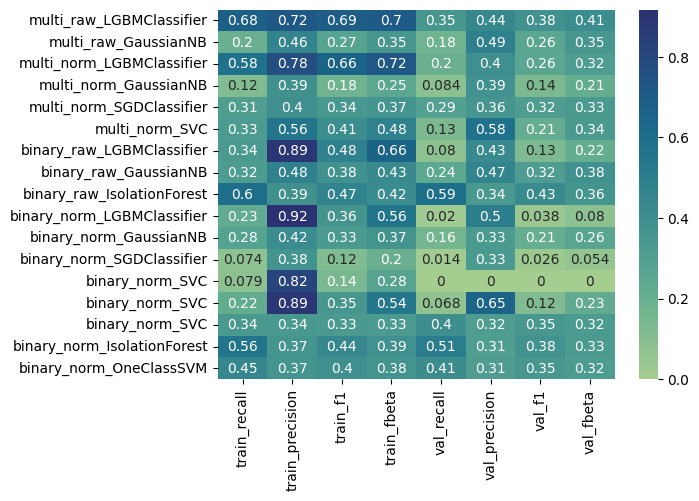

In [34]:
sns.heatmap(result_table, annot=True, cmap="crest")
